Load necessary packages

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score


**Synthetic Dataset Generation**

In [101]:
def generate_custom_data(samples_per_class=180):
    np.random.seed(42)
    centers = [
        [1, 1],
        [4, 7],
        [8, 3],
        [3, 10],
        [9, 9]
    ]

    X_list = []
    y_list = []

    for class_idx, center in enumerate(centers):
        class_data = np.random.randn(samples_per_class, 2) * 0.9 + np.array(center)
        X_list.append(class_data)
        y_list += [class_idx] * samples_per_class

    X = np.vstack(X_list)
    y = np.array(y_list)

    return X, y

X, y = generate_custom_data()

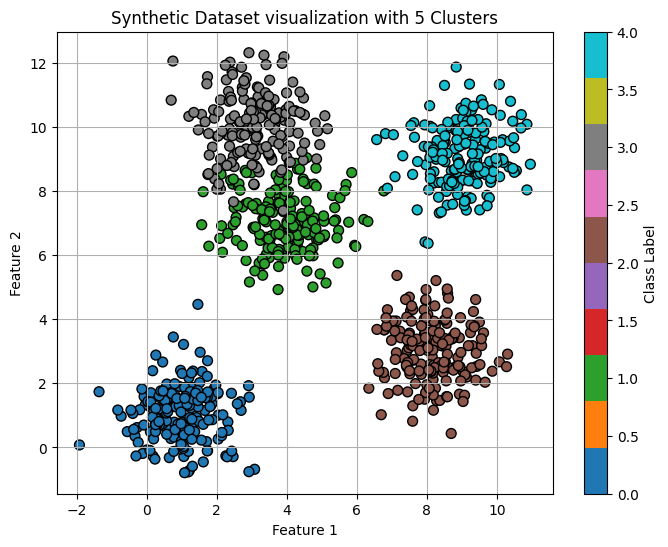

In [102]:
# Synthetic data visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', edgecolor='k', s=50)
plt.title("Synthetic Dataset visualization with 5 Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Class Label')
plt.grid(True)
plt.show()



In [196]:
print("First 5 samples from dataset:")
print("X:", X[:5])
print("y:", y[:5])

First 5 samples from dataset:
X: [[-1.12716502 -1.43477699]
 [-1.08449817 -1.02017961]
 [-1.33371539 -1.45870324]
 [-0.82124023 -1.20874812]
 [-1.40021942 -1.2648685 ]]
y: [0 0 0 0 0]


In [197]:
# One-hot encode the labels for multi-class classification
ohe = OneHotEncoder(sparse_output=False)
y_encoded = ohe.fit_transform(y.reshape(-1, 1))

# Splitting dataset into Training(60%) and Temp(40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42, stratify=y)

#Splitting the Temp set into Validation(20%) and Test(20%) set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1))


Defining Neural Network

In [188]:
class NeuralNetwork:
    def __init__(self, input_size, hidden1, hidden2, hidden3, output_size, learning_rate=0.01):
        self.lr = learning_rate
        self.W1 = np.random.randn(input_size, hidden1) * np.sqrt(1. / input_size)
        self.b1 = np.zeros((1, hidden1))
        self.W2 = np.random.randn(hidden1, hidden2) * np.sqrt(1. / input_size)
        self.b2 = np.zeros((1, hidden2))
        self.W3 = np.random.randn(hidden2, hidden3) * np.sqrt(1. / input_size)
        self.b3 = np.zeros((1, hidden3))
        self.W4 = np.random.randn(hidden3, output_size) * np.sqrt(1. / input_size)
        self.b4 = np.zeros((1, output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.sigmoid(self.Z2)
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.sigmoid(self.Z3)
        self.Z4 = np.dot(self.A3, self.W4) + self.b4
        self.output = self.softmax(self.Z4)
        return self.output

    def compute_loss(self, Y, Y_hat):
        m = Y.shape[0]
        loss = -np.sum(Y * np.log(Y_hat + 1e-8)) / m
        return loss

    def backward(self, X, Y):
        m = Y.shape[0]

        dZ4 = self.output - Y
        dW4 = np.dot(self.A3.T, dZ4) / m
        db4 = np.sum(dZ4, axis=0, keepdims=True) / m

        dA3 = np.dot(dZ4, self.W4.T)
        dZ3 = dA3 * self.sigmoid_derivative(self.A3)
        dW3 = np.dot(self.A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.sigmoid_derivative(self.A2)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.sigmoid_derivative(self.A1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1


Training Model

In [194]:
# Training
nn = NeuralNetwork(input_size=2, hidden1=32, hidden2=32, hidden3=32, output_size=5, learning_rate=0.001)
epochs = 1000
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    output = nn.forward(X_train)
    train_loss = nn.compute_loss(y_train, output)
    train_losses.append(train_loss)
    train_pred = np.argmax(output, axis=1)
    train_true = np.argmax(y_train, axis=1)
    train_acc = accuracy_score(train_true, train_pred)
    train_accuracies.append(train_acc)

    nn.backward(X_train, y_train)

    val_output = nn.forward(X_val)
    val_loss = nn.compute_loss(y_val, val_output)
    val_losses.append(val_loss)
    val_pred = np.argmax(val_output, axis=1)
    val_true = np.argmax(y_val, axis=1)
    val_acc = accuracy_score(val_true, val_pred)
    val_accuracies.append(val_acc)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")


Epoch 0: Train Loss = 2.4088, Val Loss = 2.4045, Train Acc = 0.2000, Val Acc = 0.2000
Epoch 100: Train Loss = 2.0936, Val Loss = 2.0907, Train Acc = 0.2000, Val Acc = 0.2000
Epoch 200: Train Loss = 1.9012, Val Loss = 1.8991, Train Acc = 0.2352, Val Acc = 0.2611
Epoch 300: Train Loss = 1.7846, Val Loss = 1.7828, Train Acc = 0.3370, Val Acc = 0.3556
Epoch 400: Train Loss = 1.7128, Val Loss = 1.7110, Train Acc = 0.3796, Val Acc = 0.3944
Epoch 500: Train Loss = 1.6661, Val Loss = 1.6643, Train Acc = 0.3778, Val Acc = 0.3722
Epoch 600: Train Loss = 1.6328, Val Loss = 1.6309, Train Acc = 0.3593, Val Acc = 0.3389
Epoch 700: Train Loss = 1.6063, Val Loss = 1.6042, Train Acc = 0.3167, Val Acc = 0.3111
Epoch 800: Train Loss = 1.5832, Val Loss = 1.5810, Train Acc = 0.4611, Val Acc = 0.4722
Epoch 900: Train Loss = 1.5620, Val Loss = 1.5596, Train Acc = 0.4500, Val Acc = 0.4444


Testing Model

In [200]:
test_output = nn.forward(X_test)
test_pred = np.argmax(test_output, axis=1)
test_true = np.argmax(y_test, axis=1)
test_acc = accuracy_score(test_true, test_pred)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Test Accuracy: 39.44%


Loss and Accuracy Visualization

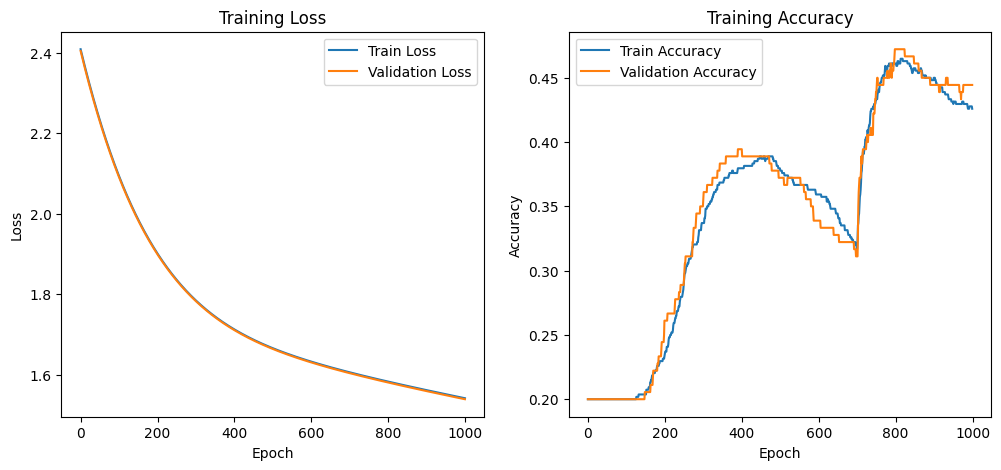

In [201]:

# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


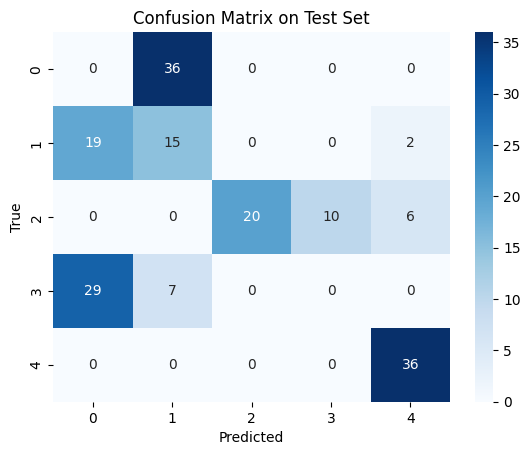

In [202]:
# Confusion Matrix
cm = confusion_matrix(test_true, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

**Documentation:**
The provided code was modified to implement a three-hidden-layer neural network for multi-class classification using synthetic data. A dataset with 900 samples (180 for each class) was generated. The hidden layer  was expanded to three layers, each containing 32 neurons, and the output layer was designed with 5 neurons to represent the five classes. Sigmoid activation functions were used in the hidden layers, while the output layer was replaced with softmax to handle multi-class predictions. The provided codebase used mean squared error (MSE), which is suitable for binary classification.It was replaced with categorical cross-entropy loss, which is more appropriate for comparing predicted probability distributions with one-hot encoded labels. The dataset was split into training, validation, and test sets. Proper evaluation was conducted using accuracy metrics, loss curves, classification reports, and a confusion matrix.


**Results and Analysis:**
The neural network failed to  perform in multi-class classification. It produces very low accuracy.